In [1]:
"""
Download dataset:

https://www.kaggle.com/rounakbanik/the-movies-dataset
"""
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings; warnings.filterwarnings('ignore');

import os
import scipy
import pandas as pd
import numpy as np
from ast import literal_eval

import parallel

N_JOBS = 10
SOURCE = os.path.expanduser("~/RecSys_Classification/")

#Read Data
ratings_path = os.path.join(
    SOURCE,
    'data/ratings.csv')
ratings = pd.read_csv(ratings_path)

item_f_path = os.path.join(
    SOURCE,
    'data/movies_metadata.csv')
item_features = pd.read_csv(item_f_path)

credits_path = os.path.join(
    SOURCE,
    'data/credits.csv')
credits = pd.read_csv(credits_path)

# Merge data sources

In [2]:
#Merge Data
item_features['id'] = pd.to_numeric(
    item_features['id'], 
    errors='coerce')
credits['id'] = pd.to_numeric(
    credits['id'], 
    errors='coerce')

credits = credits[~credits['id'].isnull()]
item_features = item_features[~item_features['id'].isnull()]

item_features.drop_duplicates('id', inplace=True)
credits.drop_duplicates('id', inplace=True)

item_features['id'] = item_features['id'].astype(int)
credits['id'] = credits['id'].astype(int)

item_features.index = item_features['id']
credits.index = credits['id']

# Filter Items

In [3]:
idx = set(
    item_features.index.tolist()
).intersection(
    credits.index.tolist()
)
idx = list(idx)
len(idx)

item_features = item_features[item_features.index.isin(idx)]
credits = credits[credits.index.isin(idx)]

item_features = pd.concat([
    item_features,
    credits.loc[item_features.index]],
    axis=1)
item_features = item_features.drop('id', axis=1)

ratings = ratings[ratings['movieId'].isin(item_features.index)]

# Compute Classification Target

In [4]:
def literal_eval_(x):
    try:
        return literal_eval(x)
    except:
        return []
    
#Getting target
item_features['genres'] = item_features['genres'].apply(
    lambda x: [y['name'] for y in literal_eval_(x) ])

genres = item_features['genres'].tolist() 
all_genres = list(set([y for x in genres for y in x]))
print("|".join(all_genres))

all_genres = pd.Series(all_genres)
all_genres.head()

target = item_features['genres'].apply(
    lambda x: all_genres.isin(x))

target.columns = all_genres
target = target.apply(
    lambda x: x / x.sum(), axis=1)

target.head()

Action|Fantasy|Horror|Crime|Foreign|Family|Western|Drama|Documentary|Animation|History|Thriller|TV Movie|Comedy|Music|Romance|Science Fiction|Adventure|War|Mystery


,Action,Fantasy,Horror,Crime,Foreign,Family,Western,Drama,Documentary,Animation,History,Thriller,TV Movie,Comedy,Music,Romance,Science Fiction,Adventure,War,Mystery
id,,,,,,,,,,,,,,,,,,,,
862,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0
8844,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.0
15602,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,0.500000,0.0,0.000000,0.0,0.0
31357,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0
11862,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


# Item Features

Read data an basic data transformation (genres as array & target)

In [5]:
#Year
item_features['year'] = pd.to_datetime(
    item_features['release_date'], 
    errors='coerce').dt.year

def count_json(x):
    try:
        return len(literal_eval(x))
    except:
        return []

#Crew and Cast Sizes
for f in ['cast', 'crew']:
    new_feature = "%s_size" % f
    item_features[new_feature] = parallel.apply(
        count_json,
        item_features[f],
        n_jobs=N_JOBS)

#Ensure Numeric
for f in ['vote_count', 'vote_average', 'budget', 'popularity', 'revenue']:
    item_features[f] = pd.to_numeric(
        item_features[f], 
        errors='coerce')
    
#Language
def parse_spok_lan(x):
    return [y['name'] for y in literal_eval_(x)]

item_features['spoken_languages'] = parallel.apply(
    parse_spok_lan,
    item_features['spoken_languages'])

languages = item_features['spoken_languages']
all_languages = list(set([y for x in languages for y in x]))
print("|".join(all_languages))

all_languages = pd.Series(all_languages)

spoken_languages = item_features['spoken_languages'].apply(
    lambda x: all_languages.isin(x))

spoken_languages.columns = all_languages
spoken_languages.index = item_features.index

spoken_languages = spoken_languages.add_prefix("language_")
spoken_languages.head()

#Concat Num.Features and Language Features
numeric_features = item_features[[
    'budget',
    'popularity',
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'year',
    'cast_size',
    'crew_size']]

i_features = pd.concat([
    numeric_features,
    spoken_languages.astype(int)],
    axis=1)

|Afrikaans|Latin|العربية|svenska|Wolof|ქართული|Hrvatski|shqip|ਪੰਜਾਬੀ|Kinyarwanda|Galego|Bahasa indonesia|Cymraeg|עִבְרִית|தமிழ்|Íslenska|Hausa|Bamanankan|한국어/조선말|Malti|ภาษาไทย|Fulfulde|Lietuvikai|Esperanto|Slovenščina|Português|??????|فارسی|广州话 / 廣州話|ελληνικά|Bokmål|Somali|Bosanski|Català|Türkçe|қазақ|普通话|Español|Український|తెలుగు|Italiano|বাংলা|Srpski|Kiswahili|euskera|Magyar|Český|Slovenčina|Deutsch|isiZulu|Bahasa melayu|Eesti|Dansk|Norsk|Nederlands|suomi|हिन्दी|Tiếng Việt|български език|پښتو|?????|English|No Language|اردو|ozbek|Français|Azərbaycan|Gaeilge|日本語|Pусский|беларуская мова|Latviešu|Polski|Română


In [6]:
i_features.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,cast_size,crew_size,language_,...,language_ozbek,language_Français,language_Azərbaycan,language_Gaeilge,language_日本語,language_Pусский,language_беларуская мова,language_Latviešu,language_Polski,language_Română
id,,,,,,,,,,,,,,,,,,,,,
862,30000000,21.946943,373554033.0,81.0,7.7,5415.0,1995.0,13,106,0,...,0,0,0,0,0,0,0,0,0,0
8844,65000000,17.015539,262797249.0,104.0,6.9,2413.0,1995.0,26,16,0,...,0,1,0,0,0,0,0,0,0,0
15602,0,11.712900,0.0,101.0,6.5,92.0,1995.0,7,4,0,...,0,0,0,0,0,0,0,0,0,0
31357,16000000,3.859495,81452156.0,127.0,6.1,34.0,1995.0,10,10,0,...,0,0,0,0,0,0,0,0,0,0
11862,0,8.387519,76578911.0,106.0,5.7,173.0,1995.0,12,7,0,...,0,0,0,0,0,0,0,0,0,0


# Concat. movie title in transactions

In [7]:
item_id_to_name = item_features['title'].to_dict()

def get_title(x):
    if x in item_id_to_name: 
        return item_id_to_name[x]
    else:
        np.nan

ratings['title'] = parallel.apply(
    get_title,
    ratings['movieId'],
    n_jobs=N_JOBS)

# Remove popular Items

In [8]:
pop = ratings['title'].value_counts()

#2 std. above the average
pop_th = pop.mean() + (2 * pop.std())
pop = pop[pop <  pop_th]

ratings = ratings[ratings['title'].isin(pop.index)]

# Train/Test candidates

In [11]:
ORI_ID_USER = 'userId'
ORI_ID_ITEM = 'movieId'

SEQ_ID_USER = 'user_id'
SEQ_ID_ITEM = 'item_id'

In [12]:
ratings['id_transaction'] = range(ratings.shape[0])
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

split_date = pd.datetime(
    year=2017,
    month=1,
    day=1)

train = ratings[ratings['timestamp'] < split_date]
test = ratings[ratings['timestamp'] >= split_date]

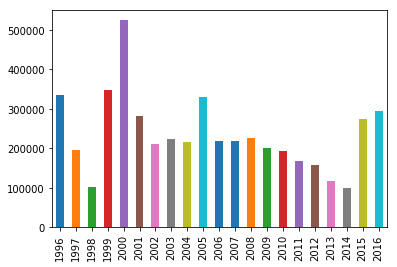

In [13]:
train['timestamp'].dt.year.value_counts().sort_index().plot(kind='bar')

## Summary

In [14]:
print("Train data:\t%s (#users: %s #items:%s)" % (
    train.shape[0],
    len(train[ORI_ID_USER].unique()),
    len(train[ORI_ID_ITEM].unique())))

print("Test data:\t%s (#users: %s #items:%s)" % (
    test.shape[0],
    test[ORI_ID_USER].nunique(),
    test[ORI_ID_ITEM].nunique()))

Train data:	4940431 (#users: 218501 #items:7029)
Test data:	182583 (#users: 10071 #items:5245)


# Assign new sequencial user/item IDs (after having fixed train/test data)

In [15]:
IDorigin_IDuser = {}
IDuser_IDorigin = {}
for id_user, id_origin in enumerate(ratings[ORI_ID_USER].unique()):
    IDorigin_IDuser[id_origin] = id_user
    IDuser_IDorigin[id_user] = id_origin

IDorigin_IDitem = {}
IDitem_IDorigin = {}
for id_item, id_origin in enumerate(ratings[ORI_ID_ITEM].unique()):
    IDorigin_IDitem[id_origin] = id_item
    IDitem_IDorigin[id_item] = id_origin

num_users = len(IDorigin_IDuser)
num_items = len(IDorigin_IDitem)

ratings[SEQ_ID_USER] = ratings[ORI_ID_USER].apply(lambda x: IDorigin_IDuser[x])
ratings[SEQ_ID_ITEM] = ratings[ORI_ID_ITEM].apply(lambda x: IDorigin_IDitem[x])

train = ratings[ratings['id_transaction'].isin(train['id_transaction'])]
test = ratings[ratings['id_transaction'].isin(test['id_transaction'])]

print("#Users:%s #Items:%s sparsity: %s" % (
    num_users,
    num_items,
    round(1 - (ratings.shape[0] / (num_users * num_items)), 5)
))

#Users:224959 #Items:7294 sparsity: 0.99688


In [16]:
train.to_hdf(
    os.path.join(SOURCE, "data/train.hdf" ), key='train')

test.to_hdf(
    os.path.join(SOURCE, "data/test.hdf" ), key='test')

## Build item catalog

In [17]:
item_features = item_features[item_features.index.isin( ratings[ORI_ID_ITEM].unique() )]
item_features[SEQ_ID_ITEM] = pd.Series(item_features.index).apply(
    lambda x: IDorigin_IDitem[x]).values

item_cat_f = [
    'title', 
    'popularity', 
    'genres',
    'year',
    SEQ_ID_ITEM]

item_catalog = item_features[item_cat_f].copy()
item_catalog.drop_duplicates(
    list(set(item_cat_f)-set(['genres'])),
    inplace=True)

item_catalog.index = item_catalog[SEQ_ID_ITEM]

item_catalog.sort_values(SEQ_ID_ITEM, inplace=True)
print(item_catalog.shape)
item_catalog.head()

(7294, 5)


,title,popularity,genres,year,item_id
item_id,,,,,
0,The 400 Blows,7.268688,[Drama],1959.0,0
1,The Mystery of Chess Boxing,0.342469,"[Action, Foreign]",1979.0,1
2,Caesar Must Die,9.737921,"[Drama, Documentary]",2012.0,2
3,Talk to Her,6.648278,"[Drama, Romance]",2002.0,3
4,Hero,9.861765,"[Drama, Adventure, Action, History]",2002.0,4


In [18]:
item_catalog.to_hdf(
    os.path.join(SOURCE, "data/item_catalog.hdf" ),
    key='item_catalog')